### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [1]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [3]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [5]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Basic Neuron Function

<img src="..\karpathy\img\Basic Neuron Function.png">

### Simple Neural Network MLP(2, [3, 3, 1])<br>* input layer: 2 nodes<br>* hidden layer 1: 3 nodes<br>* hidden layer 2: 3 nodes<br>*  output layer: 1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Hidden Layer Matrix Operations<br>* Hidden layer with two inputs (X1, X2), and three neurons (b1, b2, b3)<br>* Two sets of inputs (X1, X2) are shown in different shades of gray<br>* Two sets of outputs (Y1, Y2, Y3) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

In [6]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# inputs
xs = [
  [2.0, 3.0],
  [3.0, -1.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

### Parameters in MLP(2, [3, 3, 1])<br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = 9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = 4<br>* Total 25 parameters 

In [7]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

Number of parameters in MLP(2, [3, 3, 1]): 25

i:  0,  -0.8421551440
i:  1,   0.0723389503
i:  2,  -0.9359519026
i:  3,  -0.1933517182
i:  4,  -0.6729403344
---
i: 20,   0.6802104046
i: 21,   0.2043608216
i: 22,   0.6523593721
i: 23,   0.2406822492
i: 24,   0.2602266220


### ---- Start: Manual Calculation of Output and Loss ----

##### Transpose inputs xs

In [8]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  3.],
       [ 3., -1.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 3., -1.]])]


##### Get Neural Network's Weights and Biases Matrices

In [9]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 3
----
layer: 0, neuron 0
w0: -0.8421551,   w0.grad:  0.0000000
w1:  0.0723390,   w1.grad:  0.0000000
b:  -0.9359519

layer: 0, neuron 1
w0: -0.1933517,   w0.grad:  0.0000000
w1: -0.6729403,   w1.grad:  0.0000000
b:  -0.6104558

layer: 0, neuron 2
w0:  0.7965034,   w0.grad:  0.0000000
w1:  0.8431053,   w1.grad:  0.0000000
b:   0.0062005

------
layer: 1, neuron_cnt: 3
----
layer: 1, neuron 0
w0: -0.0892851,   w0.grad:  0.0000000
w1:  0.7366116,   w1.grad:  0.0000000
w2:  0.8746133,   w2.grad:  0.0000000
b:  -0.4959429

layer: 1, neuron 1
w0: -0.4706892,   w0.grad:  0.0000000
w1: -0.2386927,   w1.grad:  0.0000000
w2: -0.0204109,   w2.grad:  0.0000000
b:   0.3729192

layer: 1, neuron 2
w0: -0.7393307,   w0.grad:  0.0000000
w1:  0.8598633,   w1.grad:  0.0000000
w2:  0.3541904,   w2.grad:  0.0000000
b:   0.6802104

------
layer: 2, neuron_cnt: 1
----
layer: 2, neuron 0
w0:  0.2043608,   w0.grad:  0.0000000
w1:  0.6523594,   w1.grad:  0.0000000
w2:  0.240

##### Print Neural Network's Weights and Biases Matrices

In [10]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(3, 2):
[[-0.84215514  0.07233895]
 [-0.19335172 -0.67294033]
 [ 0.79650338  0.84310525]]
b_mat(1, 3):
[[-0.9359519  -0.61045584  0.00620051]]

i: 1
w_mat(3, 3):
[[-0.08928511  0.73661159  0.87461327]
 [-0.47068916 -0.2386927  -0.02041091]
 [-0.73933071  0.85986331  0.35419041]]
b_mat(1, 3):
[[-0.49594288  0.37291921  0.6802104 ]]

i: 2
w_mat(1, 3):
[[0.20436082 0.65235937 0.24068225]]
b_mat(1, 1):
[[0.26022662]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

In [11]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
err_sq = ((yout - ys)**2)
loss_sum = err_sq.sum()
loss_mean = err_sq.mean()

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'err_sq:             {err_sq}')
print(f'loss_sum:           {loss_sum}')
print(f'loss_mean:          {loss_mean}')


--------------------------------------------------
layer: 0
weights (3, 2):
[[-0.84215514  0.07233895]
 [-0.19335172 -0.67294033]
 [ 0.79650338  0.84310525]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[-1.46729344 -2.59880438]
 [-2.40552444  0.09288518]
 [ 4.12232253  1.5464049 ]]

bias (3, 1):
[[-0.9359519 ]
 [-0.61045584]
 [ 0.00620051]]

weights_x_inputs_plus_bias (3, 2):
[[-2.40324534 -3.53475628]
 [-3.01598028 -0.51757066]
 [ 4.12852303  1.55260541]]

output (3, 2):
[[-0.98377962 -0.99830015]
 [-0.99520993 -0.47582287]
 [ 0.99948129  0.91421435]]

--------------------------------------------------
layer: 1
weights (3, 3):
[[-0.08928511  0.73661159  0.87461327]
 [-0.47068916 -0.2386927  -0.02041091]
 [-0.73933071  0.85986331  0.35419041]]

input (3, 2):
[[-0.98377962 -0.99830015]
 [-0.99520993 -0.47582287]
 [ 0.99948129  0.91421435]]

weights_x_inputs (3, 2):
[[0.2289133  0.5382207 ]
 [0.68020343 0.56480456]
 [0.22560066 0.65273729]]

bias (3, 1):
[[-0.4959428

### ---- End: Manual Calculation of Output and Loss ----

### TODO calculate w1 gradient by incrementing w1

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [12]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'err_sq:             {err_sq}')
print(f'loss_sum:           {loss_sum}')
print(f'loss_mean:          {loss_mean}')


-- micrograd forward pass calculation --
ypred_data:         [0.7117908323608235, 0.7430221765247834]
ys:                 [1.0, -1.0]
err_sq:             [0.08306452431126693, 3.0381263078571936]
loss_sum:           3.1211908321684607
loss_mean:          1.5605954160842304


#### Micrograd backward pass and update parameters

In [13]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.8421551440     0.0008272041           0.05000        -0.8421965042
  1      0.0723389503     0.0071636433           0.05000         0.0719807682
  2     -0.9359519026     0.0009520418           0.05000        -0.9359995046
  3     -0.1933517182     0.4657893189           0.05000        -0.2166411841
  4     -0.6729403344    -0.1570566959           0.05000        -0.6650874996
  5     -0.6104558430     0.1551000527           0.05000        -0.6182108457
  6      0.7965033847     0.1483484857           0.05000         0.7890859604
  7      0.8431052520    -0.0496685854           0.05000         0.8455886813
  8      0.0062005082     0.0494295779           0.05000         0.0037290293
  9     -0.0892851133    -0.2647079212           0.05000        -0.0760497173
 10      0.7366115852    -0.0976631065           0.05000         0.7414947405
 11      0.8746132668     0.2370734826

### Improve Prediction with Parameter Iteration 

In [14]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.6209066339333676), Value(data = 0.6498726377302138)]
step: 0, loss: 2.8657915009265826
-------
ypred: [Value(data = 0.4956994324950637), Value(data = 0.5201449549011528)]
step: 1, loss: 2.5651597462972284
-------
ypred: [Value(data = 0.3460324132819894), Value(data = 0.36398307900012783)]
step: 2, loss: 2.288123444276448
-------
ypred: [Value(data = 0.20723393859381217), Value(data = 0.21835641005951392)]
step: 3, loss: 2.1128703700505858
-------
ypred: [Value(data = 0.11124478005410587), Value(data = 0.11671799306676169)]
step: 4, loss: 2.0369449170201306
-------
ypred: [Value(data = 0.05734227717175818), Value(data = 0.058527996534176986)]
step: 5, loss: 2.009085101854385
-------
ypred: [Value(data = 0.029870909229226156), Value(data = 0.027732429884213757)]
step: 6, loss: 1.9973844001954384
-------
ypred: [Value(data = 0.016479407417314886), Value(data = 0.011628390126521242)]
step: 7, loss: 1.9907047557441733
-------
ypred: [Value(data = 0.010206596139622288)

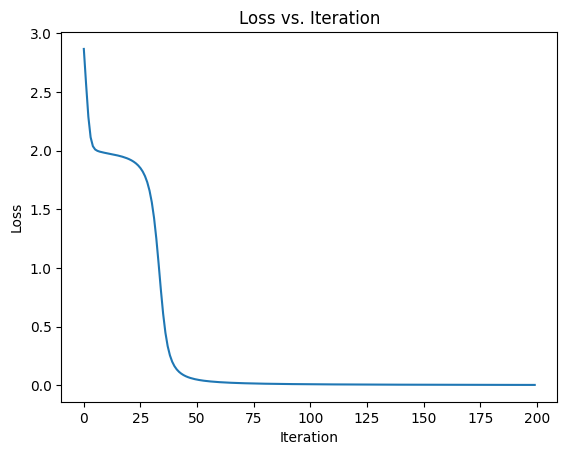

In [15]:
plot_losses(losses)

### Build same model with pyTorch 

In [16]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 0.8944522142410278
Epoch 10 loss: 0.050363823771476746
Epoch 20 loss: 0.00036262418143451214
Epoch 30 loss: 1.9863400666508824e-06

Prediction:
tensor([[ 0.9999],
        [-0.9999]])
Loss: 1.8200616125341185e-08


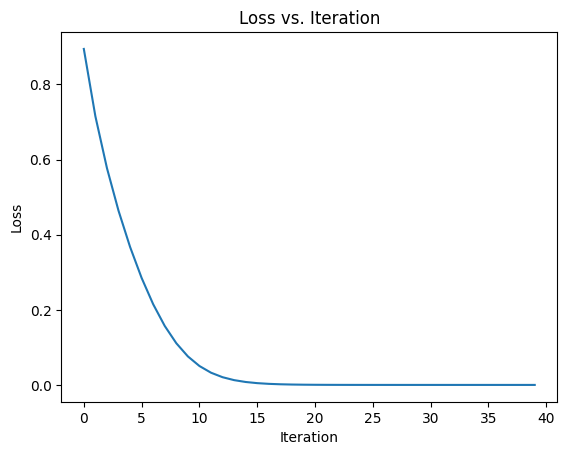

In [17]:
plot_losses(losses)

In [18]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.4320, -0.4068,  0.0657],
        [ 0.1677, -0.5020,  0.3478],
        [ 0.1895, -0.1395,  0.1369],
        [ 0.2007, -0.5452, -0.3898]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-2.1500, -0.8563],
        [-1.5183,  1.1790],
        [-0.1763,  0.7764],
        [-0.8445,  0.9525]])

bT,  torch.Size([4, 1]):
tensor([[-0.3823],
        [ 0.2050],
        [ 0.5283],
        [-0.4017]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-2.5323, -1.2386],
        [-1.3133,  1.3840],
        [ 0.3520,  1.3047],
        [-1.2462,  0.5508]])

output,  torch.Size([4, 2]):
tensor([[-0.9874, -0.8450],
        [-0.8651,  0.8819],
        [ 0.3381,  0.8629],
        [-0.8472,  0.5011]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.0577,  0.355

In [19]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [20]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9999, -0.9999]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(1.0805e-08)

In [21]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9999, -0.9999]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-5.0366e-05,  1.3810e-04]])
squared_difference: tensor([[2.5367e-09, 1.9073e-08]])


tensor(1.0805e-08)

In [22]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9999496340751648, -0.9998618960380554]

In [23]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

1.0804715344647775e-08


In [24]:
len(squared_difference)


1

In [25]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(1.0805e-08)

In [26]:
torch.sum((output - torch.tensor(ys))**2)


tensor(2.1609e-08)

##### Check Output and Gradient Calculation with PyTorch

In [27]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [28]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [29]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,  -0.9627354317
i:  1,  -0.7200995109
i:  2,  -0.5294406037
i:  3,  -0.3255771667
i:  4,  -0.1882503735
---
i: 36,   0.8819355871
i: 37,   0.2578092668
i: 38,   0.5531841859
i: 39,  -0.3298153319
i: 40,   0.9939609390


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [30]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [31]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0: -0.9627354,   w0.grad:  0.0000000
w1: -0.7200995,   w1.grad:  0.0000000
w2: -0.5294406,   w2.grad:  0.0000000
b:  -0.3255772

layer: 0, neuron 1
w0: -0.1882504,   w0.grad:  0.0000000
w1:  0.3272965,   w1.grad:  0.0000000
w2:  0.2509364,   w2.grad:  0.0000000
b:  -0.8916622

layer: 0, neuron 2
w0: -0.0824149,   w0.grad:  0.0000000
w1:  0.4081694,   w1.grad:  0.0000000
w2:  0.6741420,   w2.grad:  0.0000000
b:  -0.8034486

layer: 0, neuron 3
w0: -0.7665800,   w0.grad:  0.0000000
w1:  0.3952222,   w1.grad:  0.0000000
w2: -0.1372611,   w2.grad:  0.0000000
b:  -0.7238925

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0:  0.9705651,   w0.grad:  0.0000000
w1:  0.5149971,   w1.grad:  0.0000000
w2: -0.7869400,   w2.grad:  0.0000000
w3:  0.0694082,   w3.grad:  0.0000000
b:  -0.1758308

layer: 1, neuron 1
w0:  0.2796673,   w0.grad:  0.0000000
w1: -0.6813183,   w1.grad:  0.0000000
w2:  0.9965673,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [32]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[-0.96273543 -0.72009951 -0.5294406 ]
 [-0.18825037  0.32729647  0.25093642]
 [-0.08241493  0.40816937  0.67414202]
 [-0.76657998  0.3952222  -0.13726107]]
b_mat(1, 4):
[[-0.32557717 -0.89166222 -0.80344861 -0.72389255]]

i: 1
w_mat(4, 4):
[[ 0.97056514  0.5149971  -0.78693998  0.06940823]
 [ 0.27966727 -0.68131832  0.9965673  -0.96415044]
 [ 0.54114602  0.85556262  0.36828234  0.57303287]
 [ 0.67915194  0.87644611 -0.50730442 -0.87182275]]
b_mat(1, 4):
[[-0.17583081  0.53576242  0.23058171 -0.77847742]]

i: 2
w_mat(1, 4):
[[ 0.88193559  0.25780927  0.55318419 -0.32981533]]
b_mat(1, 1):
[[0.99396094]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [33]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.96273543 -0.72009951 -0.5294406 ]
 [-0.18825037  0.32729647  0.25093642]
 [-0.08241493  0.40816937  0.67414202]
 [-0.76657998  0.3952222  -0.13726107]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[-3.55632879 -2.43282709]
 [ 0.35445223 -0.76657937]
 [ 0.38553624 -0.31834315]
 [-0.21023228 -2.76359269]]

bias (4, 1):
[[-0.32557717]
 [-0.89166222]
 [-0.80344861]
 [-0.72389255]]

weights_x_inputs_plus_bias (4, 2):
[[-3.88190596 -2.75840425]
 [-0.53721    -1.6582416 ]
 [-0.41791237 -1.12179176]
 [-0.93412483 -3.48748523]]

output (4, 2):
[[-0.99915069 -0.99199486]
 [-0.49087313 -0.92997995]
 [-0.39517026 -0.80819125]
 [-0.73251124 -0.99813176]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.97056514  0.5149971  -0.78693998  0.06940823]
 [ 0.27966727 -0.68131832  0.9965673  -0.96415044]
 [ 0.54114602  0.85556262  0.36828234  0.57303287]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [34]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.23821855523695984, 0.21923421480856373]
ys:                 [1.0, -1.0]
loss_data:          2.0668430401451197


#### Micrograd backward pass and update parameters

In [35]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.9627354317     0.0303177802           0.05000        -0.9642513207
  1     -0.7200995109    -0.0129184242           0.05000        -0.7194535897
  2     -0.5294406037     0.0060756897           0.05000        -0.5297443881
  3     -0.3255771667     0.0098502452           0.05000        -0.3260696789
  4     -0.1882503735    -0.1526408046           0.05000        -0.1806183333
  5      0.3272964655    -0.2625350148           0.05000         0.3404232163
  6      0.2509364242     0.0885290597           0.05000         0.2465099712
  7     -0.8916622221    -0.0793725667           0.05000        -0.8876935937
  8     -0.0824149300    -0.2193731792           0.05000        -0.0714462711
  9      0.4081693709     0.0364210559           0.05000         0.4063483181
 10      0.6741420166    -0.0232155285           0.05000         0.6753027930
 11     -0.8034486061    -0.0764610601

### Improve Prediction with Parameter Iteration 

In [36]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.06027715782671931), Value(data = 0.009647274695321763)]
step: 0, loss: 1.9024666394019192
-------
ypred: [Value(data = 0.0445247406786087), Value(data = -0.046844272874167266)]
step: 1, loss: 1.821438811328055
-------
ypred: [Value(data = 0.10569271978278669), Value(data = -0.07828550212748286)]
step: 2, loss: 1.6493431270378958
-------
ypred: [Value(data = 0.317676591925823), Value(data = -0.13809202802959894)]
step: 3, loss: 1.2084505853520895
-------
ypred: [Value(data = 0.6001918278798446), Value(data = -0.29218665257286197)]
step: 4, loss: 0.6608463092900702
-------
ypred: [Value(data = 0.663561517566777), Value(data = -0.4709264585476545)]
step: 5, loss: 0.3931096647268969
-------
ypred: [Value(data = 0.7178403911207505), Value(data = -0.5681445371527375)]
step: 6, loss: 0.2661131856739144
-------
ypred: [Value(data = 0.7581296013780221), Value(data = -0.6303797630057054)]
step: 7, loss: 0.19512040932527297
-------
ypred: [Value(data = 0.7889370980959087), 

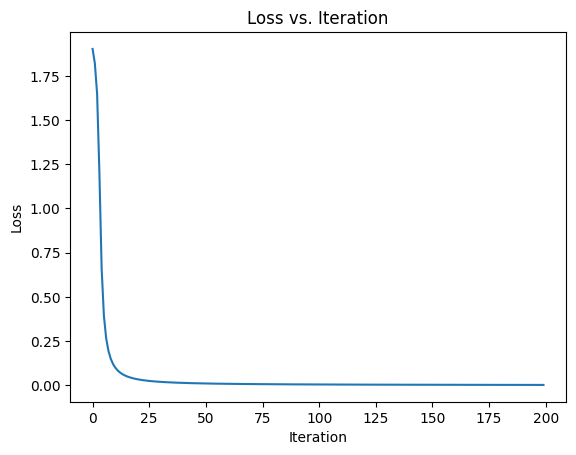

In [37]:
plot_losses(losses)

### Build same model with pyTorch 

In [38]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 2.2964746952056885
Epoch 10 loss: 0.4762929379940033
Epoch 20 loss: 0.02532806806266308
Epoch 30 loss: 0.0005137841799296439

Prediction:
tensor([[ 0.9994],
        [-0.9956]])
Loss: 1.481742765463423e-05


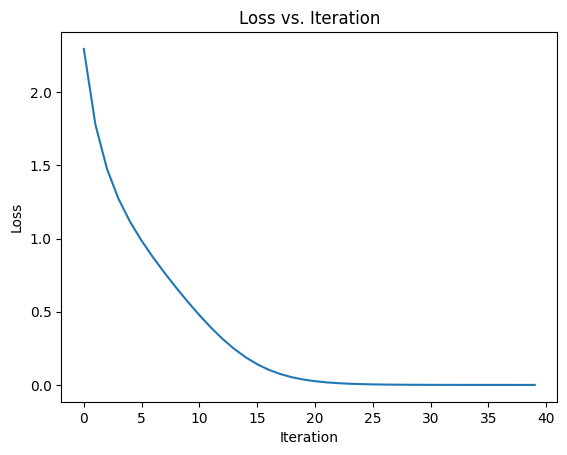

In [39]:
plot_losses(losses)

In [40]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.4602,  0.1719,  0.6784],
        [ 0.4791,  0.4752, -0.2096],
        [ 0.4061, -0.5889, -0.0201],
        [ 0.4957, -0.4599,  0.1445]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 0.7578,  1.5480],
        [ 2.5935,  0.8573],
        [-0.9343,  1.7972],
        [-0.5329,  2.0192]])

bT,  torch.Size([4, 1]):
tensor([[-0.5577],
        [-0.4238],
        [-0.4730],
        [-0.2376]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 0.2002,  0.9903],
        [ 2.1698,  0.4335],
        [-1.4072,  1.3242],
        [-0.7705,  1.7816]])

output,  torch.Size([4, 2]):
tensor([[ 0.1975,  0.7575],
        [ 0.9743,  0.4082],
        [-0.8869,  0.8678],
        [-0.6472,  0.9449]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.0845, -0.215

In [41]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [42]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9994, -0.9956]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(1.9985e-05)

In [43]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9994, -0.9956]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0006,  0.0044]])
squared_difference: tensor([[3.1706e-07, 1.9668e-05]])


tensor(9.9924e-06)

In [44]:
difference
len(squared_difference)

1

In [45]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(9.9924e-06)

In [46]:
torch.sum((output - torch.tensor(ys))**2)

tensor(1.9985e-05)